# Laugh test 3: Pressure in layered soils
This notebook plots SUMMA simulations for the test case defined in Vanderborght et al. (2005). 

## Expectations
The simulations should reproduce the analytical solutions in Figure 2 in Vanderborght et al. (2005):

<div>
<img src="img/vanderborght2005_fig2.png" width="800"/>
    <center> Figures 2 in Vanderborght et al. (2005) </center>
</div>

## Meta data

| Data  | Value  |
|:---|:---|
| Model name| Structure for Unifying Multiple Modelling Alternatives (SUMMA) |
| Model version  |  See attributes in output .nc file |
| Model reference | Clark et al. (2015a,b) |
| Model runs by | R. Zolfaghari |
| Notebook code by | W. Knoben, A. Bennett |
    
## Reference(s)
Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Rasmussen, R. M. (2015a). A unified approach for process-based hydrologic modeling: 1. Modeling concept. Water Resources Research, 51(4), 2498–2514. https://doi.org/10.1002/2015WR017198

Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Marks, D. G. (2015b). A unified approach for process-based hydrologic modeling: 2. Model implementation and case studies. Water Resources Research, 51, 2515–2542. https://doi.org/10.1002/2015WR017200

Vanderborght, J., R. Kasteel, M. Herbst, M. Javaux, D. Thiery, M. Vanclooster, C. Mouvet, and H. Vereecken, 2005: A set of analytical benchmarks to test numerical models of flow and transport in soils. VADOSE ZONE JOURNAL, 4 (1), 206–221

In [6]:
# modules
%pylab inline
import xarray as xr
import matplotlib as mpl
from scipy.optimize import newton

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [7]:
# Load data
ds1 = xr.open_dataset('./output/vanderborght2005_exp1_output_timestep.nc').isel(hru=0, gru=0, time=0).load()
ds1 = ds1.where(ds1['mLayerDepth'] != -9999, drop=True)
ds1['mLayerMatricHead'] = ds1['mLayerMatricHead'].isel(midToto=0)

ds2 = xr.open_dataset('./output/vanderborght2005_exp2_output_timestep.nc').isel(hru=0, gru=0, time=0).load()
ds2 = ds2.where(ds2['mLayerDepth'] != -9999, drop=True)
ds2['mLayerMatricHead'] = ds2['mLayerMatricHead'].isel(midToto=0)

ds3 = xr.open_dataset('./output/vanderborght2005_exp3_output_timestep.nc').isel(hru=0, gru=0, time=0).load()
ds3 = ds3.where(ds3['mLayerDepth'] != -9999, drop=True)
ds3['mLayerMatricHead'] = ds3['mLayerMatricHead'].isel(midToto=0)

In [8]:
# Analytical solution
def k_psi(psi, ksat, alpha, n, m):
    if psi < 0:
        return ksat * ( 
            ( ( (1 - (psi*alpha)**(n-1) * (1 + (psi*alpha)**n)**(-m))**2) /  
              ( (1 + (psi*alpha)**n)**(m/2))))
    else:
        return ksat

    
def solve_psi(psi, q, ksat, alpha, n, m):
    return q - k_psi(psi, ksat, alpha, n, m)


def integrate_psi(psi0, psi1, qIn, ksat, alpha, n, m):
    psi = np.linspace(psi0, psi1, num=100)
    dpsi = psi[1] - psi[0]
    return -np.sum([dpsi / ((qIn / k_psi(p, ksat, alpha, n, m)) - 1) for p in psi])


def vanderborght_analytic(top_soil, bottom_soil, q=0.5, 
                          max_iters=100, delx_max=2., tol=1e-12, delpsi_scale=0.3):
    psi_init = -25.
    ksat, alpha, n, m = param_dict[bot_soil]
    psi_bot = newton(solve_psi, psi_init, args=(q, ksat, alpha, n, m), maxiter=500)
    
    ksat, alpha, n, m= param_dict[top_soil]
    psi_top = newton(solve_psi, psi_init, args=(q, ksat, alpha, n, m), maxiter=500)
    
    psi = np.linspace(psi_bot, psi_top, num=500)
    depths = np.zeros_like(psi)
    depths[0] = 50.
    
    for i, (psi0, psi1) in enumerate(zip(psi[:-1], psi[1:])):
        psi0_base = psi0
        psi1_base = psi1
        dpsi = psi1_base - psi0
        depths[i + 1] = depths[i]
        
        for trial in range(max_iters):
            psi1 = psi0 + dpsi
            if dpsi > 0:
                psi1 = max(psi1, psi1_base)
            else:
                psi1 = min(psi1, psi1_base)
            dpsi = psi1 - psi0
            
            delx = integrate_psi(psi0, psi1, q, ksat, alpha, n, m)
            if np.abs(delx) > delx_max:
                dpsi *= delpsi_scale
            else:
                psi0 = psi1
                depths[i+1] += delx
            if abs(psi0 - psi1_base) < tol:
                break
    return psi, depths

In [9]:
# Plotting settings
M_TO_CM = 100.
soil_tuples = [('loam', 'sand'), ('sand', 'loam'), ('clay', 'sand')]
param_dict = {
    # Soil - ksat , alpha,   n,  m
    'sand': (1000., -0.15, 3.0, 1-1/3.0),
    'loam': (  50., -0.04, 1.6, 1-1/1.6),
    'clay': (  10., -0.01, 1.1, 1-1/1.1)
}

ValueError: must supply either single 'dim' or 'axis' argument to cumsum

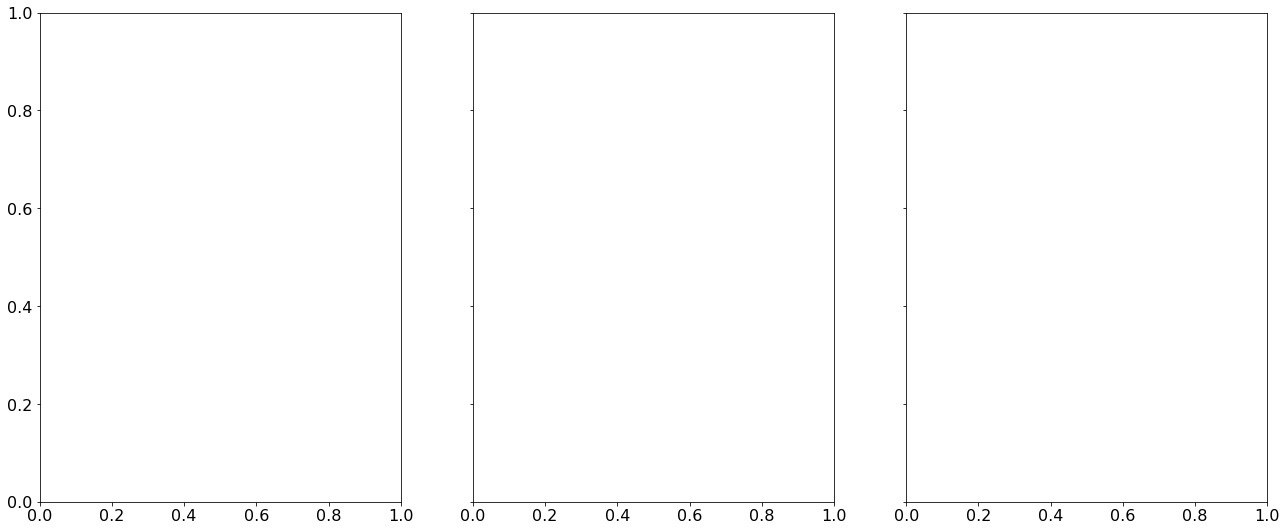

In [10]:
# Plot
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(22, 9))
for i, (ds, (top_soil, bot_soil)) in enumerate(zip([ds1, ds2, ds3], soil_tuples)):
    axes[i].plot(M_TO_CM * ds['mLayerMatricHead'], M_TO_CM * np.cumsum(ds['mLayerDepth'].values.flatten(), axis=0) - 1, color='red', label='Simulated')
    axes[i].axhline(50, linestyle='--', color='grey')
    axes[i].set_ylim([0, 100])
    axes[i].set_xlim([-50, 0])
    axes[i].invert_yaxis()
    axes[i].set_xlabel('matric head (cm)', size=22)
    axes[i].text(-40, 44, soil_tuples[i][0], size=20)
    axes[i].text(-40, 58, soil_tuples[i][1], size=20)
    
    psi, depths = vanderborght_analytic(top_soil, bot_soil)
    axes[i].plot(psi, depths, linestyle='--', color='black')
    psi_bot = psi[np.argmax(depths)]
    axes[i].plot([psi_bot, psi_bot], [50, 100], linestyle='--', color='black')
    if min(depths) > 0:
        psi_surf = psi[np.argmin(depths)]
        axes[i].plot([psi_surf, psi_surf], [0, min(depths)], linestyle='--', color='black', label='Analytic')

axes[1].legend(fontsize=16)
axes[0].set_ylabel('depth (cm)', size=22)
plt.savefig('./img/lt3_vanderborght2005.png')